## Tarea 1, parte 1
### Esteban Jiménez Henríquez

   **1- Propiedades de NGC121**

   NGC121 es un cúmulo globular que pertenece a la pequeña nube de magallanes. Tiene una magnitud aparente de
   11.24 en el filtro V y un módulo de distancia de 18.94. También tiene un diámetro de 53.7 parsecs. 
   
   Referencia: [NED](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=NGC121&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES)
   
   **2- Extracción y análisis**
   
   Analizando el header de la primera extensión de cada imagen se puede observar que ACS corresponde al instrumento
   que utiliza el telescopio y HRC es el detector que capta los fotones.··
   Por otro lado, F555W y F814W son filtros centrados, aproximadamente, en 555 nm y 814 nm respectivamente. En compa-
   ración con el sistema Johnson, el primer filtro es una superposición de los filtros B y V y el otro corresponde muy
   bien con la pasabanda I.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

#hdu_f555w = fits.open('hst_10396_a4_acs_hrc_f555w_drz.fits')
#hdu_f814w = fits.open('hst_10396_a4_acs_hrc_f814w_drz.fits')

Abrimos las imagenes y extraemos sus primeras dos extensiones; estas corresponden a la imagen de ciencia y la imagen
que contiene el inverso de las varianzas. En el siguiente bloque denominamos *SCI* a las imagenes de ciencia y *WHT*
a los pesos. De esta manera, separamos las imagenes de ciencia con sus respectivas imagenes de peso produciendo en total 4 nuevos fits (que conservan el header de los fit original). Se puede comprobar que tanto SCI_f555w como SCI_f814w están alineadas.

In [ ]:
SCI_f555w = (hdu_f555w['SCI']).writeto('sci_f555w_ngc121.fits')
WHT_f555w = hdu_f555w['WHT'].writeto('invar_f555w_ngc121.fits')
SCI_f814w = hdu_f814w['SCI'].writeto('sci_f814w_ngc121.fits')
WHT_f814w = hdu_f814w['WHT'].writeto('invar_f814w_ngc121.fits')
hdu_f555w.close()
hdu_f814w.close()

**3- Usando SExtractor ** 

Para realizar fotometría utlizando los parámetros deseados, se debe editar el archivo de configuración para cada imagen de ciencia: f555w_config.txt y f814w_config.txt; cada uno de estos arhivos contiene la información que SExtractor utiliza para realizar fotometría. Dentro de los parámetros se debe ajustar el ancho de la apertura, el threshold,el Gain, etc.

En nuestro caso, el ancho de la apertura es de 6 pixeles y utilizamos las imagenes de peso extraidas en el inciso anterior. Además, se editó el archivo de output para que nos entregará las magnitudes, sus errores y las coordenas de Ascension recta y declinación para cada objeto analizado. 

En esta carpeta se encuentran los dos archivos (de configuración y de output) para cada filtro y al final se dará una descripción más detallada de los parámetros utilizados en los archivos de configuración. Además, se han adjuntado dos imagenes fits (f814w_ap.fits y f555w_ap.fits) que muestra la apertura que se hace a las estrellas de la imagen. 

**4- Obtención de CMD para NGC121**

Usando el módulo de Python *astropy.coordinates* se hiso un mach de las estrellas de los filtros de manera de poder calcular el exceso de color (ya sea azul o rojo) para cada estrella. 

In [3]:
# Guardamos los datos de los outputs en dos arrays y luego extraemos los vectores de RA y DEC de cada uno de estos.
MAG_f555w = np.loadtxt('output_f555w.cat')
MAG_f814w = np.loadtxt('output_f814w.cat')
RA_f555w, DEC_f555w = MAG_f555w[:,3], MAG_f555w[:,4]
RA_f814w, DEC_f814w = MAG_f814w[:,3], MAG_f814w[:,4]

# Match entre las estrellas de cada filtro
c = SkyCoord(ra=RA_f814w*u.degree, dec=DEC_f814w*u.degree)  
catalog = SkyCoord(ra=RA_f555w*u.degree, dec=DEC_f555w*u.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  

F555W = (MAG_f555w[idx])[:,1]
F814W = MAG_f814w[:,1]

El [código](http://docs.astropy.org/en/stable/coordinates/) para realizar el match busca los pares más cercanos entre los dos vectores y nos entrega el vector idx que contiene las posiciones de las estrellas del catálogo que corresponden con el el vector c (que en este caso es el output para f814w). 

Ahora, para calibrar las magnitudes en el sistema VEGAMAC debemos sumar a las magnitudes el Zeropoint correspondiente a este sistema y a cada filtro. ([Referencia](http://www.stsci.edu/hst/acs/documents/isrs/isr0702.pdf)). 

Para el caso de la corrección de apertura utilizamos los valores de la página del HST como puntos para realizar una interpolación de la corrección para un diámetro de 6 pixeles. Realizando este calculo obtenemos que para los dos filtros la corrección es de 0.15. ([Referencia](http://www.stsci.edu/hst/acs/analysis/apcorr)). También hicimos uso del *Plate Scale* para calcular cuantos arcosegundos corresponden a 6 pixeles. ([Referencia](http://www.stsci.edu/hst/acs/Detector/))

Por último, también debemos incluir la correción por el reddening que sufren los fotones provenientes del cúmulo. 
Para los dos filtros dichos valores son distintos y fueron obtenidos del [NED](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=NGC121&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES).

In [4]:
# Zeropoint
ZPT_F555W = 25.711
ZPT_F814W = 25.498

# Absortion
A_F555W = 0.101
A_F814W = 0.056

# Aperture Correction
apcor_F555W = 0.15
apcor_F814W = 0.15

# Applying corrections
F555W = F555W + ZPT_F555W -apcor_F555W -A_F555W
F814W = F814W + ZPT_F814W -apcor_F814W -A_F814W

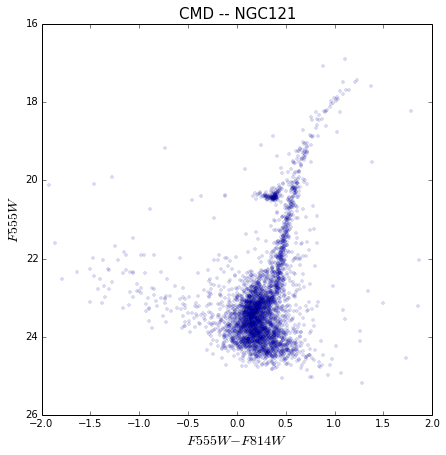

In [14]:
color = F555W-F814W
plt.figure(figsize=(7,7))
plt.plot(color,F555W,'bo',alpha=0.15,markersize =3.0)
plt.title(r"CMD -- NGC121", fontsize = 15)
plt.xlabel(r"$F555W-F814W$", fontsize = 14)
plt.ylabel(r"$F555W$", fontsize = 14)
plt.axis([-2,2,16,26])
plt.gca().invert_yaxis()